In [1]:
#!/home/was966/micromamba/envs/responder/bin/python
#sbatch --mem 64G -c 4 -t 12:00:00 -p gpu_quad --gres=gpu:rtx8000:1 ./01_cohort_to_cohort_transfer.py

import sys

sys.path.insert(0, '/home/was966/Research/mims-conceptor/')
from conceptor.utils import plot_embed_with_label
from conceptor import PreTrainer, FineTuner, loadconceptor #, get_minmal_epoch
from conceptor.utils import plot_embed_with_label, score2
from conceptor.tokenizer import CANCER_CODE

import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.3)
import warnings
warnings.filterwarnings("ignore")

def onehot(S):
    assert type(S) == pd.Series, 'Input type should be pd.Series'
    dfd = pd.get_dummies(S, dummy_na=True)
    nanidx = dfd[dfd[np.nan].astype(bool)].index
    dfd.loc[nanidx, :] = np.nan
    dfd = dfd.drop(columns=[np.nan])*1.
    cols = dfd.sum().sort_values(ascending=False).index.tolist()
    dfd = dfd[cols]
    return dfd

def random_acc(R, NR):
    positive_samples = R
    negative_samples = NR
    total_samples = positive_samples + negative_samples
    
    # For random guessing, the probability of guessing a sample correctly is:
    # (probability of guessing a positive correctly + probability of guessing a negative correctly) / total possibilities
    
    # The probability of guessing a positive sample correctly is the proportion of positive samples,
    # and similarly for negative samples.
    
    random_guess_accuracy = (positive_samples/total_samples * positive_samples/total_samples) + \
                            (negative_samples/total_samples * negative_samples/total_samples)
    return random_guess_accuracy


In [2]:
pwd

'/home/was966/Research/mims-conceptor/paper/01_model_performance/01_cohort_to_chort'

In [3]:
data_path = '../../../paper/00_data/'
df_label = pd.read_pickle(os.path.join(data_path, 'ITRP.PATIENT.TABLE'))
df_tpm = pd.read_pickle(os.path.join(data_path, 'ITRP.TPM.TABLE'))

df_task = onehot(df_label.response_label)
size = df_label.groupby('cohort').size()
size = size.index + "\n(n=" + size.astype(str) + ")"

dfcx = df_label.cancer_type.map(CANCER_CODE).to_frame('cancer_code').join(df_tpm)
dfy = df_task
cohorts = df_label.groupby('cohort').size().sort_values().index.tolist()

size.loc[cohorts]

cohort
Choueiri           Choueiri\n(n=16)
Miao                   Miao\n(n=17)
Snyder               Snyder\n(n=21)
SU2CLC2             SU2CLC2\n(n=25)
Zhao                   Zhao\n(n=25)
Hugo                   Hugo\n(n=26)
MGH                     MGH\n(n=34)
Allen                 Allen\n(n=39)
Kim                     Kim\n(n=45)
Riaz                   Riaz\n(n=51)
Gide                   Gide\n(n=73)
Rose                   Rose\n(n=89)
SU2CLC1            SU2CLC1\n(n=102)
Liu                    Liu\n(n=107)
IMmotion150    IMmotion150\n(n=165)
IMVigor210      IMVigor210\n(n=298)
dtype: object

In [4]:
#cohorts = pd.Series(cohorts).map(size).to_list()
random_acc

<function __main__.random_acc(R, NR)>

In [5]:
df_label.response_label

Index
IMVigor210-0257bb-ar-0257bbb    NR
IMVigor210-025b45-ar-025b45c    NR
IMVigor210-032c64-ar-032c642    NR
IMVigor210-0571f1-ar-0571f17    NR
IMVigor210-065890-ar-0658907     R
                                ..
Kim_NatMed_2018-p664-ar-026     NR
Kim_NatMed_2018-p666-ar-029     NR
Kim_NatMed_2018-p667-ar-030     NR
Kim_NatMed_2018-p668-ar-031      R
Kim_NatMed_2018-p669-ar-032     NR
Name: response_label, Length: 1133, dtype: object

In [6]:
cohort_rgc = df_label.groupby(['cohort']).response_label.apply(lambda x: random_acc(x.value_counts()['R'], x.value_counts()['NR'])).sort_values()
cohort_rgc

cohort
Hugo           0.502959
Gide           0.504597
Zhao           0.507200
Liu            0.527295
SU2CLC1        0.532488
MGH            0.543253
Snyder         0.555556
Allen          0.555556
SU2CLC2        0.564800
Miao           0.584775
IMmotion150    0.587438
Kim            0.608889
IMVigor210     0.647764
Riaz           0.684737
Choueiri       0.695312
Rose           0.705088
Name: response_label, dtype: float64

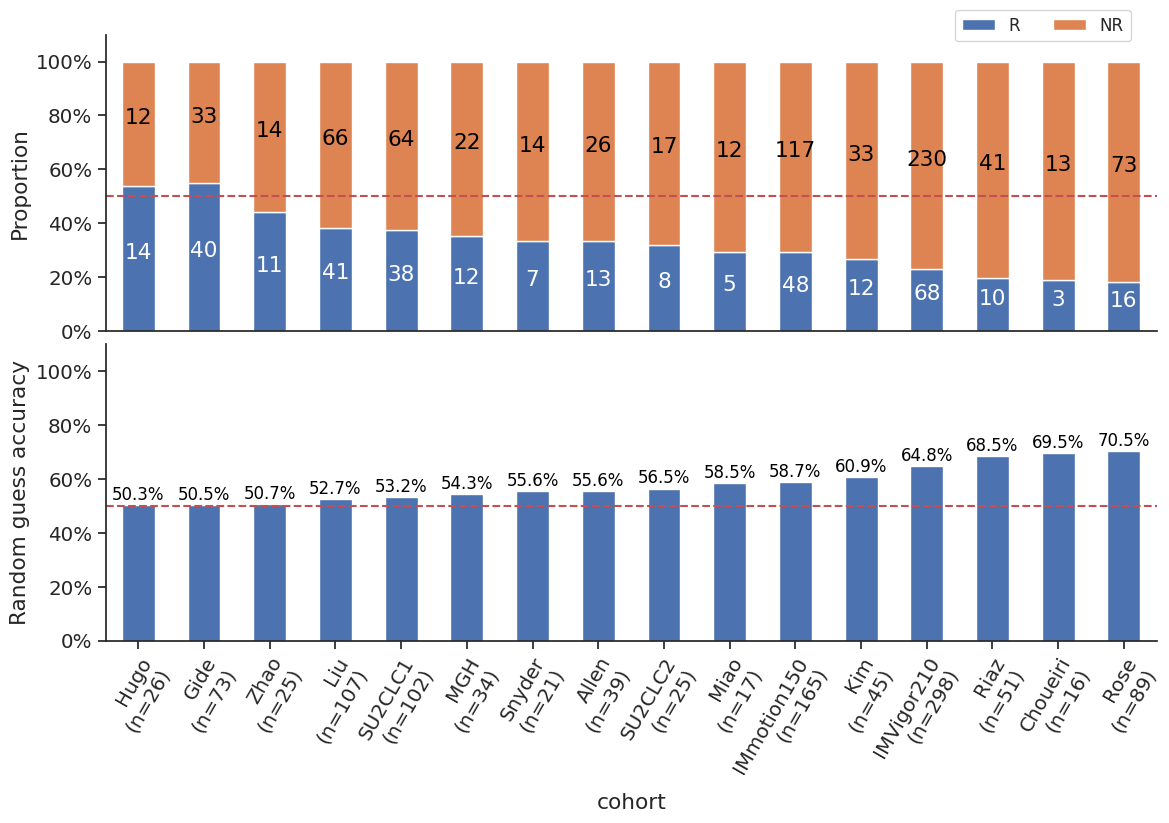

In [7]:
df = df_label.groupby(['cohort', 'response_label']).size().unstack()
df = df.loc[cohort_rgc.index]

# Normalize the R and NR values to get proportions for the stacked bar lengths
df['R_prop'] = df['R'] / (df['R'] + df['NR'])
df['NR_prop'] = df['NR'] / (df['R'] + df['NR'])


fig, (ax1, ax2) = plt.subplots(figsize=(12, 8.5), nrows=2, sharex=True, sharey=False)

# Plot a stacked bar plot with normalized proportions
df[['R_prop', 'NR_prop']].plot(kind='bar', stacked=True, ax = ax1)

h,l = ax1.get_legend_handles_labels()
ax1.legend(h[:2],["R", "NR"],  ncols =2, fancybox  = True, bbox_to_anchor =  (0.8, 0.95), fontsize=12)


# Annotate the actual numbers on the bars
for i, (index, row) in enumerate(df.iterrows()):
    # Annotate the responder count
    ax1.text(i, row['R_prop']/2, str(int(row['R'])), ha='center',color='white')
    ax1.text(i, row['R_prop'] + row['NR_prop']/2, str(int(row['NR'])), ha='center', color='black')

ax1.set_ylabel('Proportion')


cohort_rgc.sort_values().plot(kind='bar' , ax = ax2)
for i in range(len(cohort_rgc)):
    ax2.text(i, cohort_rgc.iloc[i] + 0.02 ,  '{:.1%}'.format(cohort_rgc.iloc[i]) ,
             ha='center', color='black', fontdict={'fontsize':12})

ax2.set_ylabel('Random guess accuracy')


ax1.tick_params(axis='y', which='major', right = False, top=False, direction = 'out',reset = True)
ax2.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
# #fig.savefig('./avg_refined_distribution.pdf')
ax2.set_xticklabels(
    cohort_rgc.index.map(size),
    rotation=60, 
    ha="right",  
    rotation_mode="anchor")  # <====== HERE is the ke

ax2.axhline(y=0.5, color='r', linestyle='--')
ax1.axhline(y=0.5, color='r', linestyle='--')

ax1.set_ylim(0, 1.1)
ax2.set_ylim(0, 1.1)

ax1.spines[['right', 'top']].set_visible(False)
ax2.spines[['right', 'top']].set_visible(False)

vals = ax1.get_yticks()
ax1.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

vals = ax2.get_yticks()
ax2.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

fig.tight_layout(h_pad = 0.1)
fig.savefig('./dataset_distribution_random_guess_acc.pdf')
fig.savefig('./dataset_distribution_random_guess_acc.svg')

In [8]:
from sklearn.metrics import accuracy_score, average_precision_score
accs = []
aps = []
for _ in range(1000):
    y = [1] * 10 + [0] * 90
    pred = [np.random.binomial(n=1, p=0.1)] * 100
    accs.append(accuracy_score(y, np.round(pred)))
    aps.append(average_precision_score(y, pred))

print(np.mean(accs))
print(np.mean(aps))

0.8200000000000002
0.10000000000000002


In [9]:
large_cohorts = [ 'SU2CLC1',
 'Liu',
 'IMmotion150',
 'IMVigor210']

medium_cohorts = [ 'MGH',
 'Allen',
 'Kim',
 'Riaz',
 'Gide',
 'Rose',]

small_cohort = ['Choueiri',
 'Miao',
 'Snyder',
 'SU2CLC2',
 'Zhao',
 'Hugo',]

skcm_cohorts = [
 'Hugo',
 'MGH',
 'Allen',
 'Riaz',
 'Gide',
 'Liu',]

blca_cohorts = [
 'IMVigor210',
 'Rose',
 'Snyder']

kirc_cohorts = ['Choueiri', 
                'IMmotion150', 
                'Miao']

kc = ['Kim', 'Zhao'] + large_cohorts
train_cohorts = skcm_cohorts #[ 'IMVigor210', 'Liu']#small_cohort + medium_cohorts #['IMVigor210', 'Zhao', 'IMmotion150', 'Kim', 'SU2CLC1', 'Liu']
test_cohorts = skcm_cohorts #['IMmotion150'] #[ 'IMmotion150', 'IMVigor210']

In [10]:
# IMVigor210	BLCA
# Rose	BLCA
# Snyder	BLCA
# Zhao	GBM
# Choueiri	KIRC
# IMmotion150	KIRC
# Miao	KIRC
# Kim	STAD
# SU2CLC1	LUAD
# SU2CLC2	LUSC
# Gide	SKCM
# Hugo	SKCM
# Liu	SKCM
# Riaz	SKCM
# Allen	SKCM
# MGH	SKCM

In [11]:
cohorts

['Choueiri',
 'Miao',
 'Snyder',
 'SU2CLC2',
 'Zhao',
 'Hugo',
 'MGH',
 'Allen',
 'Kim',
 'Riaz',
 'Gide',
 'Rose',
 'SU2CLC1',
 'Liu',
 'IMmotion150',
 'IMVigor210']

## loading bechmarks

In [12]:
from glob import glob
csvs = glob('./baseline_run/CTCT/CTCT_*/metric_performance.tsv')

res = []
for csv in csvs:
    df = pd.read_csv(csv, index_col =0, sep='\t')
    df = df[df.train_cohort != df.test_cohort]	
    res.append(df)

data1 = pd.concat(res)
data1.shape

(5280, 9)

## loading conceptor

In [13]:
csvs = glob('./conceptor_run/CTCT/CTCT_*/metric_performance.tsv')

res = []
for csv in csvs:
    df = pd.read_csv(csv, index_col =0, sep='\t')

    df = df[df.train_cohort != df.test_cohort]	
    df['mode'] = csv.split('/')[-2].split('_')[1]
    res.append(df)
data2 = pd.concat(res)
data2.shape

(960, 8)

## Merge & analysis

In [14]:
data = data2._append(data1).reset_index(drop=True)
data['transfer'] = data.train_cohort + '$\mapsto$ '+data.test_cohort

#data.transfer = data.transfer.apply(lambda x:x.replace('-to-', '$\mapsto$'))


data['test_cohort_RGC'] = data.test_cohort.map(cohort_rgc)

data.head()

,train_cohort,test_cohort,ROC,PRC,F1,ACC,MCC,mode,best_C,transfer,test_cohort_RGC
0,Allen,Choueiri,0.384615,0.145951,0.000000,0.625000,-0.230769,FFT,NaN,Allen$\mapsto$ Choueiri,0.695312
1,Allen,Gide,0.706818,0.703226,0.626866,0.657534,0.353794,FFT,NaN,Allen$\mapsto$ Gide,0.504597
2,Allen,Hugo,0.422619,0.518940,0.272727,0.384615,-0.218596,FFT,NaN,Allen$\mapsto$ Hugo,0.502959
3,Allen,IMVigor210,0.543478,0.281367,0.215686,0.731544,0.081530,FFT,NaN,Allen$\mapsto$ IMVigor210,0.647764
4,Allen,IMmotion150,0.617699,0.367514,0.320000,0.690909,0.149528,FFT,NaN,Allen$\mapsto$ IMmotion150,0.587438


In [15]:
data1.shape,data2.shape, data.shape

((5280, 9), (960, 8), (6240, 11))

In [16]:
datas = data[data.train_cohort.isin(train_cohorts) & data.test_cohort.isin(test_cohorts)]
datas.shape

(780, 11)

In [17]:
# data.groupby(['mode', 'train_cohort']).ROC.mean().unstack().mean(axis=1).sort_values()

In [18]:
# CTL        0.087279
# ICA        0.087926
# Teff       0.091466
# CIS        0.103539
# PFT        0.081424

In [19]:
data_mt = data[(data.ACC > data.test_cohort_RGC + 0.05) & (data.MCC > 0)]
df_mt = data_mt.groupby('mode').size().to_frame('# of Positive Transfer')

data_nt = data[(data.ACC < data.test_cohort_RGC) & (data.MCC < 0)]
df_nt = data_nt.groupby('mode').size().to_frame('# of Negative Transfer')

data['positive_transfer'] = data.index.isin(data_mt.index)
data['negative_transfer'] = data.index.isin(data_nt.index)

dft = df_mt.join(df_nt)
dft

,# of Positive Transfer,# of Negative Transfer
mode,,
CAF,14,110
CD8,58,63
CIS,78,64
CKS,45,106
CTL,81,73
CTLA4,50,71
FFT,76,44
GEP,64,68
GeneBio,67,53


In [20]:
colors = sns.color_palette('PiYG',10)
colors

[(0.7514033064206075, 0.09588619761630142, 0.4736639753940792),
 (0.8513648596693579, 0.395924644367551, 0.6446751249519416),
 (0.9231833910034601, 0.6410611303344866, 0.804152249134948),
 (0.9755478662053056, 0.8202998846597462, 0.9081891580161476),
 (0.9792387543252595, 0.9279507881584006, 0.954479046520569),
 (0.938562091503268, 0.9650903498654364, 0.8996539792387543),
 (0.8382929642445216, 0.9331026528258363, 0.7132641291810845),
 (0.6558246828143024, 0.8396770472895041, 0.4459054209919264),
 (0.4595924644367551, 0.7049596309111881, 0.23029603998462128),
 (0.2873510188389081, 0.5548635140330642, 0.1263360246059208)]

In [21]:
mt_color = colors[-2]
nt_color = colors[1]

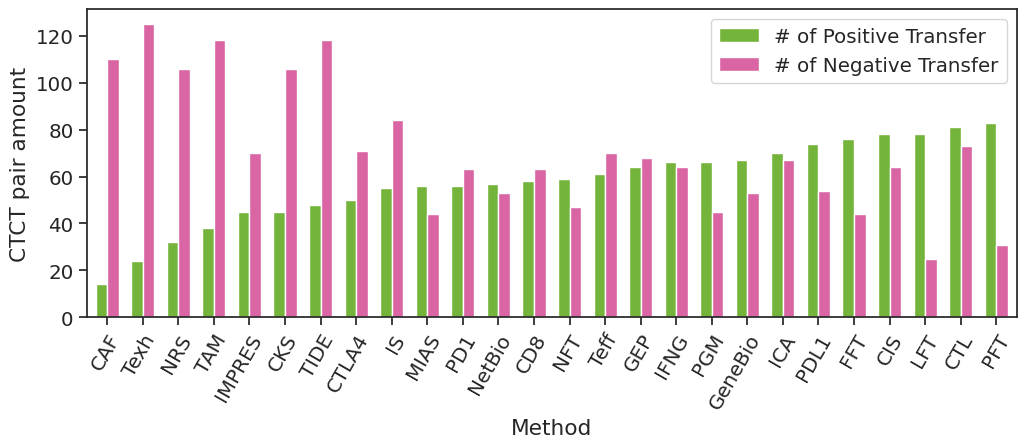

In [22]:
fig, ax = plt.subplots(figsize=(12, 4),  )

#x_order = (dft[dft.columns[1]] - dft[dft.columns[0]]).sort_values().index
x_order = (dft[dft.columns[0]]).sort_values().index

dft = dft.loc[x_order]

dft.plot(kind='bar', ax=ax, color= [mt_color, nt_color], alpha = 1, width=0.65)
ax.set_ylabel('CTCT pair amount')

ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
# # #fig.savefig('./avg_refined_distribution.pdf')
ax.set_xticklabels(
    x_order, 
    rotation=60, 
    ha="right",  
    rotation_mode="anchor")  # <====== HERE is the ke

ax.set_xlabel('Method')

fig.savefig('./all_pairs_cohort2chohorts_bar.pdf', bbox_inches='tight')

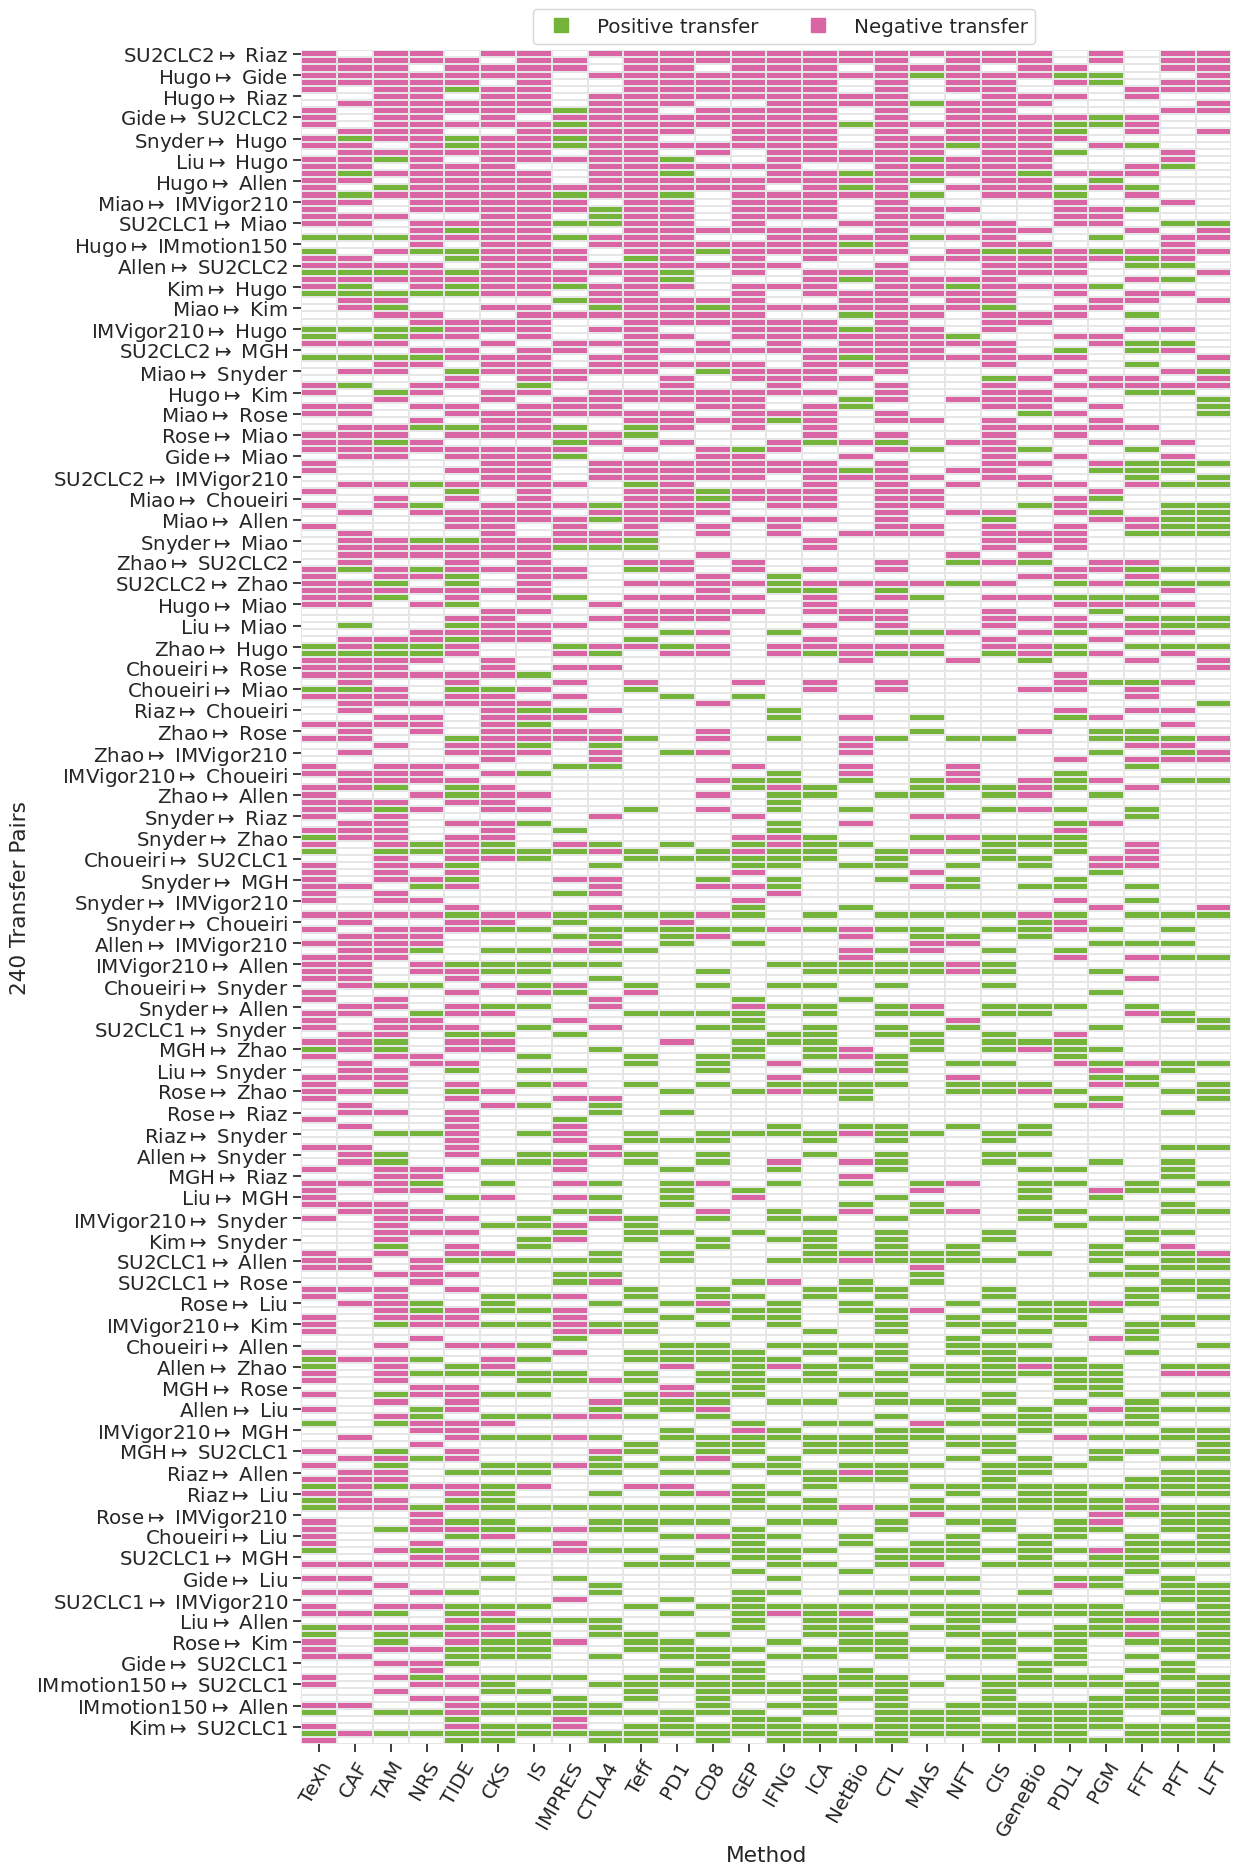

In [41]:
dfb1 = pd.pivot_table(data, columns = 'mode', index='transfer', values = 'positive_transfer' )
dfb1 = pd.DataFrame(np.where(dfb1 !=0, dfb1, np.nan), index=dfb1.index, columns= dfb1.columns)

dfb2 = pd.pivot_table(data, columns = 'mode', index='transfer', values = 'negative_transfer' )
dfb2 = pd.DataFrame(np.where(dfb2 !=0, dfb2, np.nan), index=dfb2.index, columns= dfb2.columns)


#x_order = dfb1.sum().sort_values().index
# y_order = dfb1.sum(axis=1).sort_values().index

x_order = (dfb1.sum() - dfb2.sum()).sort_values().index
l1 = dfb1[x_order[-6:]].sum(axis=1)
l2 = dfb2[x_order].sum(axis=1)

y_order = (l1-l2).sort_values().index


dfb1 = dfb1[x_order].loc[y_order]
dfb2 = dfb2[x_order].loc[y_order]

fig, ax = plt.subplots(figsize=(12, 22))
# sns.heatmap(dfb1, cmap = 'Greens', ax=ax, linewidths = 0.01)
cmap1 = sns.light_palette(mt_color, n_colors =  2, reverse=True)
cmap2 = sns.light_palette(nt_color, n_colors =  2, reverse=True)

sns.heatmap(dfb1, 
        cmap = cmap1, ax = ax, #vmax = data.max()-0.01,
        cbar=False,  #cbar_kws = dict(use_gridspec=False,location="bottom"), 
        linewidths=0.005, linecolor = '0.9')#

sns.heatmap(dfb2, 
        cmap = cmap2, ax = ax, #vmax = data.max()-0.01,
        cbar=False,  #cbar_kws = dict(use_gridspec=False,location="bottom"), 
        linewidths=0.005, linecolor = '0.9')#


ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
ax.set_xticklabels(
    x_order, 
    rotation=60, 
    ha="right",  
    rotation_mode="anchor")  # <====== HERE is the ke
ax.set_ylabel('240 Transfer Pairs')
ax.set_xlabel('Method')


l1 = plt.plot([],[], marker="s", ms=10, ls="", mec=None, color=cmap1[0], label= 'Positive transfer' )[0]
l2 = plt.plot([],[], marker="s", ms=10, ls="", mec=None, color=cmap2[0], label= 'Negative transfer' )[0]
#l3 = plt.plot([],[], marker="s", ms=10, ls="", mec=None, color=cmap2[1], label= 'Ambigorious' )[0]

patches = [l1, l2,] # l3

ax.legend(handles=patches, bbox_to_anchor=(0.80,1.03),  
          loc='upper right', ncol=3, facecolor="w", numpoints=1, ) 


dfd_pos = dfb1.sum()/len(dfb1)
dfd_neg = dfb2.sum()/len(dfb2)

dfs_pos = dfb1.sum()
dfs_neg = dfb2.sum()

fig.savefig('./all_pairs_heatmap.pdf', bbox_inches='tight')
fig.savefig('./all_pairs_heatmap.svg', bbox_inches='tight')


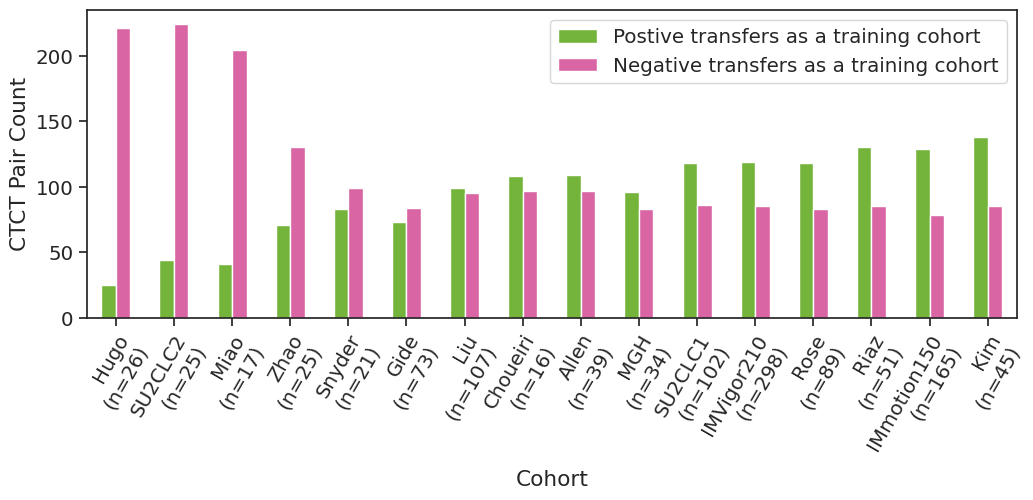

In [24]:
pt1 = data[data.positive_transfer].train_cohort.value_counts().to_frame('Postive transfers as a training cohort')
pt2 = data[data.negative_transfer].train_cohort.value_counts().to_frame('Negative transfers as a training cohort')
ptp = pt1.join(pt2)
idx = (ptp['Postive transfers as a training cohort'] - ptp['Negative transfers as a training cohort']).sort_values().index
ptp = ptp.loc[idx]

fig, ax= plt.subplots(figsize=(12, 4))
ptp.plot(kind='bar', ax=ax, color= [mt_color, nt_color],)

ax.set_ylabel('CTCT Pair Count')

ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)

ax.set_xticklabels(
    ptp.index.map(size), 
    rotation=60, 
    ha="right",  
    rotation_mode="anchor")  # <====== HERE is the ke

ax.set_xlabel('Cohort')

fig.savefig('./train_cohorts.svg', bbox_inches='tight')

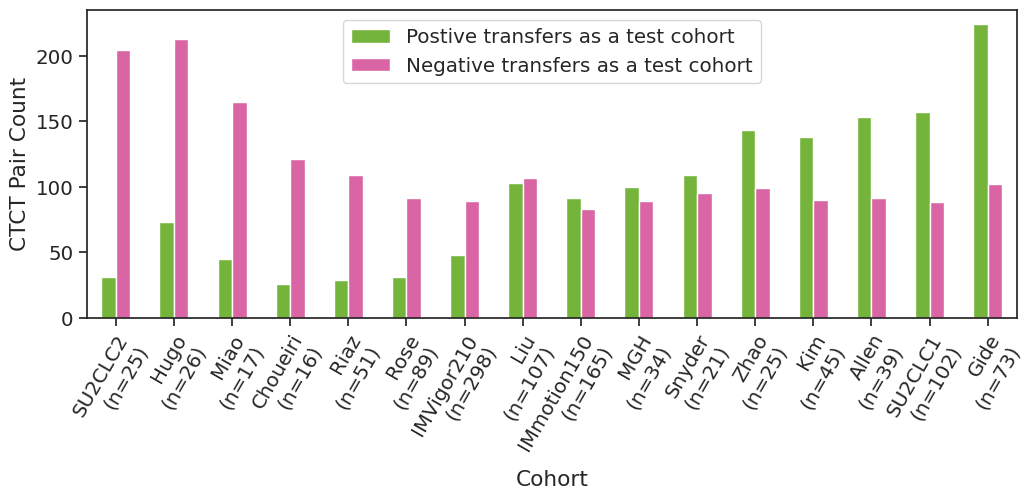

In [25]:
pt1 = data[data.positive_transfer].test_cohort.value_counts().to_frame('Postive transfers as a test cohort')
pt2 = data[data.negative_transfer].test_cohort.value_counts().to_frame('Negative transfers as a test cohort')
ptp = pt1.join(pt2)
idx = (ptp['Postive transfers as a test cohort'] - ptp['Negative transfers as a test cohort']).sort_values().index
ptp = ptp.loc[idx]

fig, ax= plt.subplots(figsize=(12, 4))
ptp.plot(kind='bar', ax=ax, color= [mt_color, nt_color],)

ax.set_ylabel('CTCT Pair Count')

ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)

ax.set_xticklabels(
    ptp.index.map(size), 
    rotation=60, 
    ha="right",  
    rotation_mode="anchor")  # <====== HERE is the ke

ax.set_xlabel('Cohort')

fig.savefig('./test_cohort.svg', bbox_inches='tight')


In [26]:
ot = '#cccccc'
f4 = sns.palettes.color_palette('hls', 4, desat = 1).as_hex()

mode_palette = { 'NFT':f4[0],'LFT':f4[1],  'PFT':f4[2], 'FFT':f4[3],
                # 'CKS':f4[4], 'GEP':f4[5],  'MIAS':f4[6],'PDL1':f4[7],
                # 'Teff':f4[8], 'GeneBio':f4[9],
                'CKS':ot, 'GEP':ot,  'MIAS':ot,'PDL1':ot,
                'Teff':ot, 'GeneBio':ot,
                'TIDE':ot, 'TAM':ot, 'Texh':ot, 'CAF':ot, 'NRS':ot, 'CTLA4':ot, 'IMPRES':ot, 'PGM':ot,
                'PD1':ot,  'NetBio':ot, 
                'CD8':ot, 'IS':ot, 'IFNG':ot, 'ICA':ot, 'CTL':ot, 'CIS':ot,
                }

In [27]:
x_order

Index(['Texh', 'CAF', 'TAM', 'NRS', 'TIDE', 'CKS', 'IS', 'IMPRES', 'CTLA4',
       'Teff', 'PD1', 'CD8', 'GEP', 'IFNG', 'ICA', 'NetBio', 'CTL', 'MIAS',
       'NFT', 'CIS', 'GeneBio', 'PDL1', 'PGM', 'FFT', 'PFT', 'LFT'],
      dtype='object', name='mode')

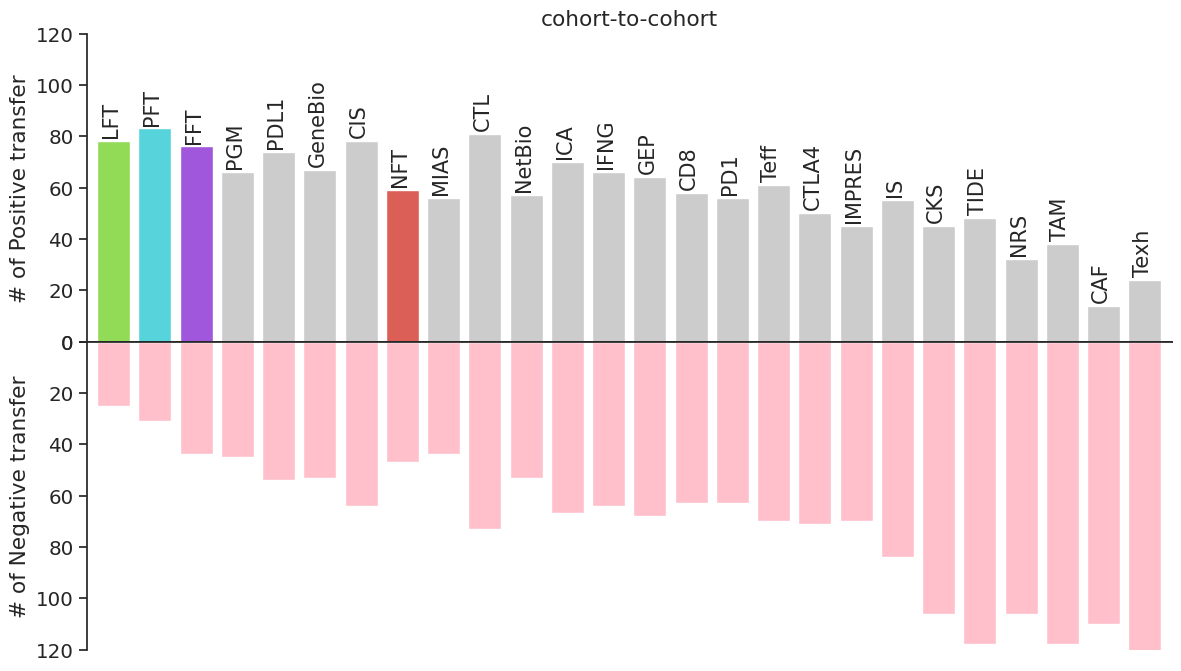

In [28]:
df_pos = pd.concat([dfs_pos], axis=1)
df_pos.columns = ['cohort2cohort']

df_neg = pd.concat([dfs_neg], axis=1)
df_neg.columns = ['cohort2cohort']

fig, axes = plt.subplots( nrows=2, ncols=1, sharey=False, figsize=(14,8))
ax1, ax4 = axes

### drug
sidx = list(x_order)
sidx.reverse() #dfs_neg.sort_values(ascending=True).index
dfp = dfs_pos.loc[sidx]

color = pd.Series(mode_palette).loc[dfp.index].to_list()
dfp.plot(kind='bar', color = color,ax=ax1, width=0.8)
i = 0
for k, y in dfp.items():
    ax1.text(i-0.3, y + 3, k, rotation=90, fontsize=15)
    i += 1

dfs_neg.loc[dfp.index].plot(kind='bar', color = 'pink',ax=ax4, width=0.8)


for i, ax in enumerate( [ax1]):
    ax.set_ylim(0.,120)
    ax.set_xticks([])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    if i != 0:
        ax.spines["left"].set_visible(False)
        ax.get_yaxis().set_ticks([])

    ax.set_xlabel('')


for i, ax in enumerate( [ax4]):
    ax.set_ylim(0.,120)
    
    ax.set_xticks([])
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.invert_yaxis()
    
    if i != 0:
        ax.spines["left"].set_visible(False)
        ax.get_yaxis().set_ticks([])

    ax.set_xlabel('')

ax1.set_ylabel('# of Positive transfer')

vals = ax1.get_yticks()
#ax1.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax1.tick_params(axis='y', which='major', right = False, top=False, direction = 'out',reset = True)


ax4.set_ylabel('# of Negative transfer')
vals = ax4.get_yticks()
#ax4.set_yticklabels(['{:,.0%}'.format(x) for x in vals[:]])
ax4.tick_params(axis='y', which='major', right = False, top=False, direction = 'out',reset = True)
ax1.set_title('cohort-to-cohort')
plt.subplots_adjust(wspace=0.1, hspace=0)
# plt.tight_layout()
fig.savefig('./c2c_performance.pdf', bbox_inches='tight')


## Melenoma Only

In [29]:
mdata = data[data.train_cohort.isin(skcm_cohorts) & data.test_cohort.isin(skcm_cohorts)]

mdata_mt = mdata[(mdata.ACC > mdata.test_cohort_RGC + 0.05) & (mdata.MCC > 0)]

mdf_mt = mdata_mt.groupby('mode').size().to_frame('# of Positive Transfer')

mdata_nt = mdata[(mdata.ACC < mdata.test_cohort_RGC) & (mdata.MCC < 0)]
mdf_nt = mdata_nt.groupby('mode').size().to_frame('# of Negative Transfer')

mdft = mdf_mt.join(mdf_nt)
mdft

,# of Positive Transfer,# of Negative Transfer
mode,,
CAF,3,15
CD8,6,7
CIS,8,10
CKS,10,12
CTL,12,10
CTLA4,11,8
FFT,3,10
GEP,8,7
GeneBio,12,8


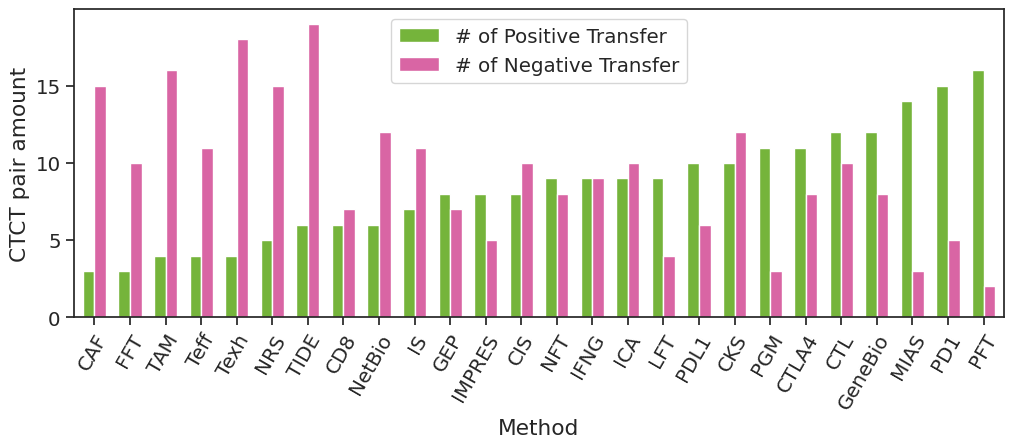

In [30]:
fig, ax = plt.subplots(figsize=(12, 4),  )

#x_order = (dft[dft.columns[1]] - dft[dft.columns[0]]).sort_values().index
x_order = (mdft[mdft.columns[0]]).sort_values().index

mdft = mdft.loc[x_order]

mdft.plot(kind='bar', ax=ax, color= [mt_color, nt_color], alpha = 1, width=0.65)
ax.set_ylabel('CTCT pair amount')

ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
# # #fig.savefig('./avg_refined_distribution.pdf')
ax.set_xticklabels(
    x_order, 
    rotation=60, 
    ha="right",  
    rotation_mode="anchor")  # <====== HERE is the ke

ax.set_xlabel('Method')

fig.savefig('./SKCM_pairs_cohort2chohorts_bar.pdf', bbox_inches='tight')

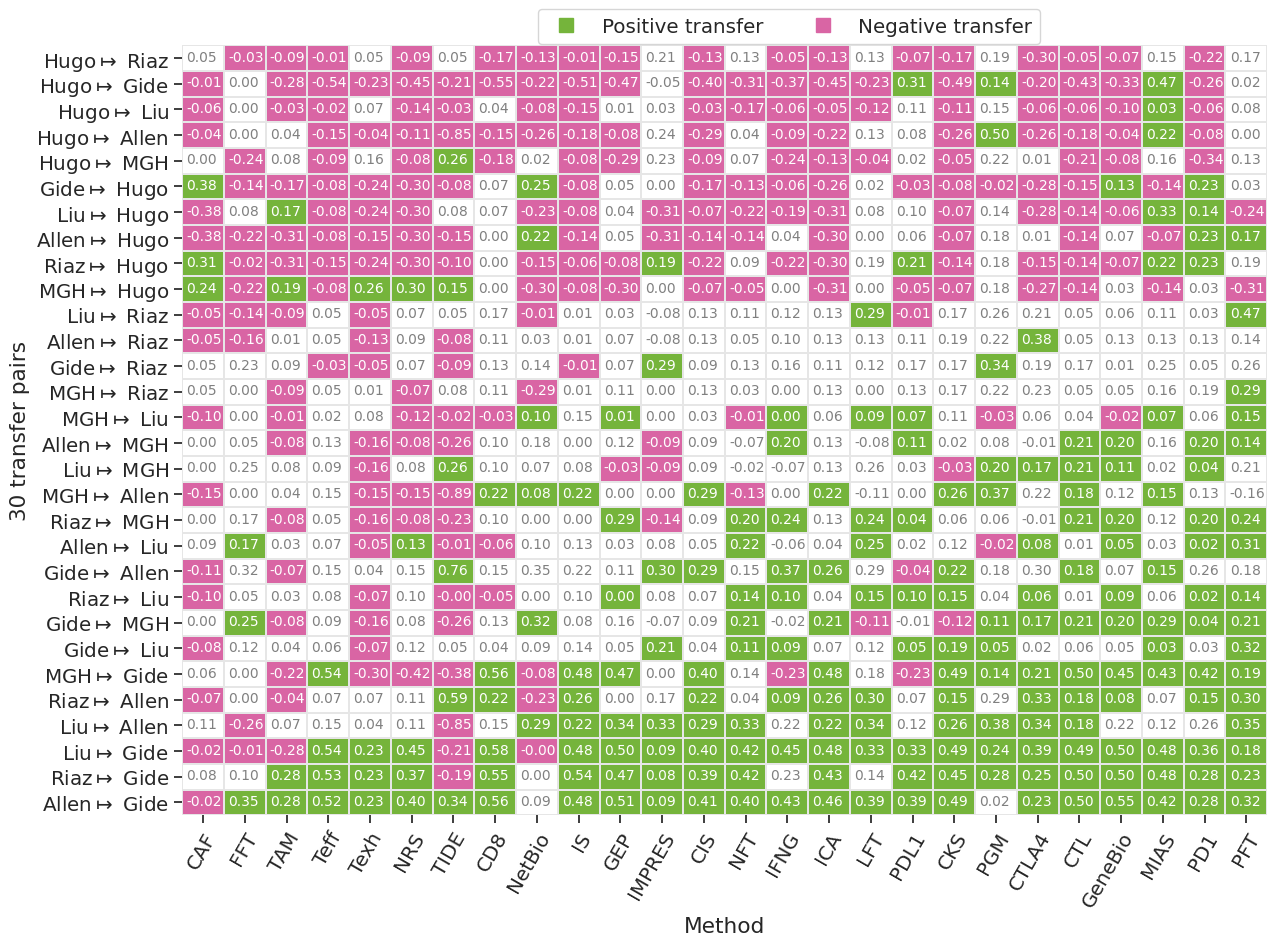

In [31]:

dfb1 = pd.pivot_table(mdata, columns = 'mode', index='transfer', values = 'positive_transfer' )
dfb1 = pd.DataFrame(np.where(dfb1 !=0, dfb1, np.nan), index=dfb1.index, columns= dfb1.columns)

dfb2 = pd.pivot_table(mdata, columns = 'mode', index='transfer', values = 'negative_transfer' )
dfb2 = pd.DataFrame(np.where(dfb2 !=0, dfb2, np.nan), index=dfb2.index, columns= dfb2.columns)

#x_order = (dfb1.sum() - dfb2.sum()).sort_values().index
y_order = (dfb1.sum(axis=1) - dfb2.sum(axis=1)).sort_values().index

# x_order = dfb1.sum().sort_values().index
# y_order = dfb1.sum(axis=1).sort_values().index

dfb1 = dfb1[x_order].loc[y_order]
dfb2 = dfb2[x_order].loc[y_order]

fig, ax = plt.subplots(figsize=(14, 10))
# sns.heatmap(dfb1, cmap = 'Greens', ax=ax, linewidths = 0.01)
cmap1 = sns.light_palette(mt_color, n_colors =  2, reverse=True)
cmap2 = sns.light_palette(nt_color, n_colors =  2, reverse=True)

sns.heatmap(dfb1, 
        cmap = cmap1, ax = ax, #vmax = data.max()-0.01,
        cbar=False,  #cbar_kws = dict(use_gridspec=False,location="bottom"), 
        linewidths=0.003, linecolor = '0.9')#

sns.heatmap(dfb2, 
        cmap = cmap2, ax = ax, #vmax = data.max()-0.01,
        cbar=False,  #cbar_kws = dict(use_gridspec=False,location="bottom"), 
        linewidths=0.003, linecolor = '0.9')#

x_axis_dict = {}
for i in ax.xaxis.get_ticklabels():
    p = i.get_position()
    k = i.get_text()
    x_axis_dict[k] = p
    
y_axis_dict = {}
for i in ax.yaxis.get_ticklabels():
    p = i.get_position()
    k = i.get_text()
    y_axis_dict[k] = p
    
for i in range(len(mdata)):
    ts = mdata.iloc[i]
    v = '%.2f' % ts.MCC
    x = ts['mode']
    y = ts.transfer
    x = x_axis_dict[x][0]-0.4
    y = y_axis_dict[y][1] + 0.1
    
    if ts.positive_transfer | ts.negative_transfer:
        color = 'white'
    else:
        color = 'gray'
    ax.text(x, y, v, fontdict={'fontsize':10, 'color':color})

ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
ax.set_xticklabels(
    x_order, 
    rotation=60, 
    ha="right",  
    rotation_mode="anchor")  # <====== HERE is the ke
ax.set_ylabel('30 transfer pairs')
ax.set_xlabel('Method')

l1 = plt.plot([],[], marker="s", ms=10, ls="", mec=None, color=cmap1[0], label= 'Positive transfer' )[0]
l2 = plt.plot([],[], marker="s", ms=10, ls="", mec=None, color=cmap2[0], label= 'Negative transfer' )[0]
#l3 = plt.plot([],[], marker="s", ms=10, ls="", mec=None, color=cmap2[1], label= 'Ambigorious' )[0]

patches = [l1, l2,] # l3

ax.legend(handles=patches, bbox_to_anchor=(0.80,1.06),  
          loc='upper right', ncol=3, facecolor="w", numpoints=1, ) 
fig.savefig('./SKCM_pairs_cohort2chohorts_heatmap.pdf', bbox_inches='tight')

In [32]:
hue_order = ['PFT', 'LFT', 'FFT', 'NFT', 'TIDE', 'NetBio',  'MIAS',  ] #'Teff' 'FFT', 'NFT','PD1', 'PDL1'

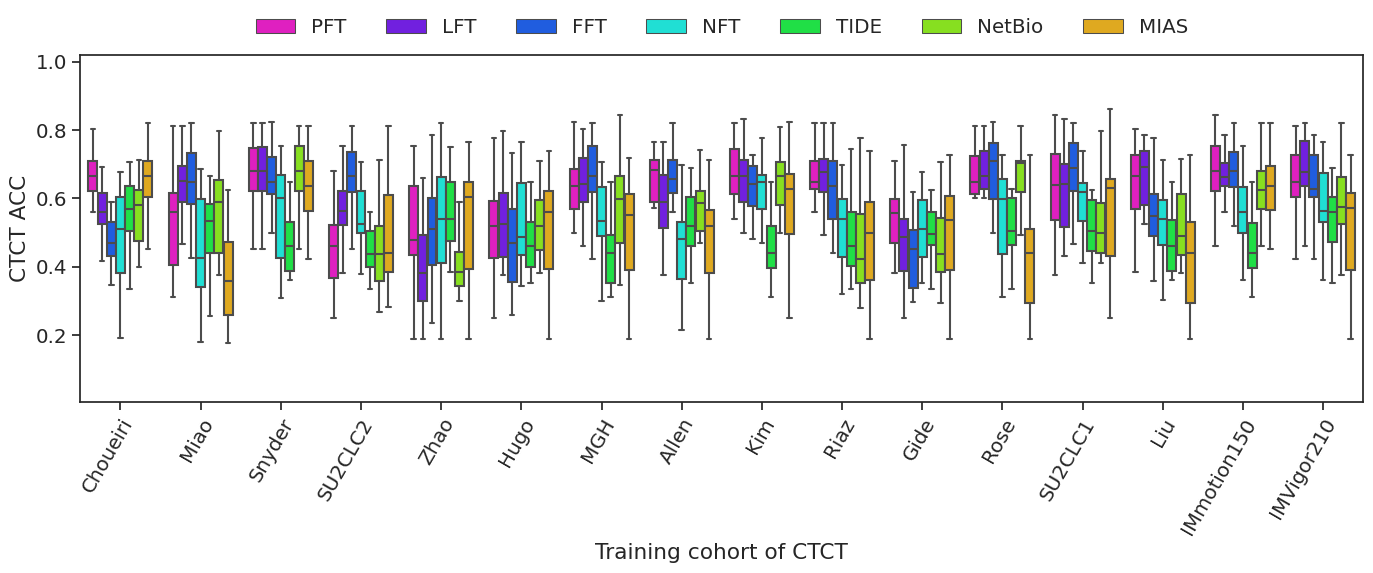

In [33]:
fig, ax = plt.subplots(figsize=(14,6))
x = 'train_cohort'
y = 'ACC'
hue = 'mode'
# order = ['PFT','PGM', 'ICA'] # 'Teff'

# data[x] = data[x]  + '\n(n='  + data['n_train'].astype(str) + ')'

x_order = cohorts

palette = sns.palettes.color_palette('hsv_r', len(hue_order))


res = []
for r in x_order:
    d1 = data[(data[x] == r)]
    res.append(d1)
datap = pd.concat(res)

# hue_order = data.groupby(['mode', 'train_cohort']).MCC.mean().unstack().mean(axis=1).sort_values().index

sns.boxplot(data = datap, x = x, y = y, hue = hue, order = x_order, #errorbar=('ci', 95),
            hue_order= hue_order, ax = ax,  palette = palette, fliersize = 0)


g = sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1),
                ncol= len(hue_order),  title=None, frameon=False)


ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
# #fig.savefig('./avg_refined_distribution.pdf')
ax.set_xticklabels(
    x_order, 
    rotation=60, 
    ha="right",  
    rotation_mode="anchor")  # <====== HERE is the ke

ax.set_xlabel('Training cohort of CTCT')
ax.set_ylabel('CTCT %s' % y)

fig.tight_layout()

fig.savefig('./all_pairs_cohort2chohorts_boxplot_ACC.pdf',  bbox_inches='tight')

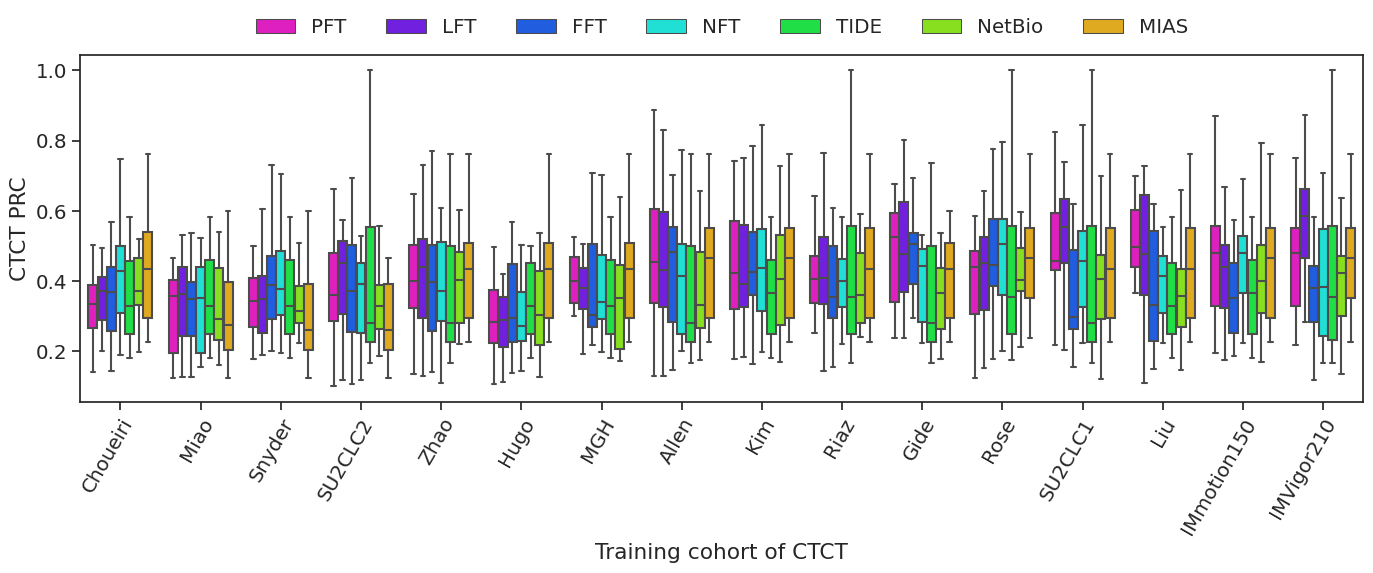

In [34]:
fig, ax = plt.subplots(figsize=(14,6))


x = 'train_cohort'
y = 'PRC'
hue = 'mode'
# order = ['PFT','PGM', 'ICA'] # 'Teff'

# data[x] = data[x]  + '\n(n='  + data['n_train'].astype(str) + ')'
x_order = cohorts
palette = sns.palettes.color_palette('hsv_r', len(hue_order))

res = []
for r in x_order:
    d1 = data[data[x] == r]
    res.append(d1)
datap = pd.concat(res)

sns.boxplot(data = datap, x = x, y = y, hue = hue, order = x_order, #errorbar=('ci', 95),
            hue_order= hue_order, ax = ax,  palette = palette, fliersize = 0)


g = sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1),
                ncol= len(hue_order),  title=None, frameon=False)


ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
# #fig.savefig('./avg_refined_distribution.pdf')
ax.set_xticklabels(
    x_order, 
    rotation=60, 
    ha="right",  
    rotation_mode="anchor")  # <====== HERE is the ke

ax.set_xlabel('Training cohort of CTCT')
ax.set_ylabel('CTCT %s' % y)

fig.tight_layout()

fig.savefig('./all_pairs_cohort2chohorts_boxplot_PRC.pdf',  bbox_inches='tight')

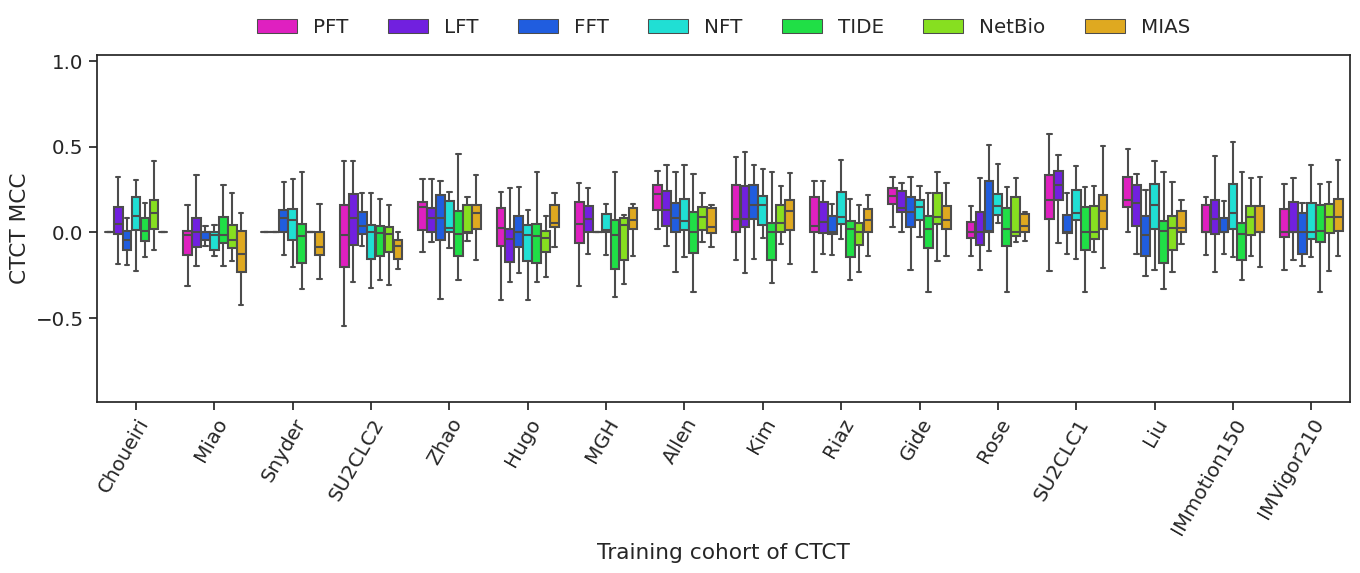

In [35]:
x = 'train_cohort'
y = 'MCC'
hue = 'mode'

x_order = cohorts
palette = sns.palettes.color_palette('hsv_r', len(hue_order))

res = []
for r in x_order:
    d1 = data[data[x] == r]
    res.append(d1)
datap = pd.concat(res)

fig, ax = plt.subplots(figsize=(14,6))

sns.boxplot(data = datap, x = x, y = y, hue = hue, order = x_order, #errorbar=('ci', 95),
            hue_order= hue_order, ax = ax,  palette = palette, fliersize = 0)

g = sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1),
                ncol= len(hue_order),  title=None, frameon=False)

#sns.lineplot(data = datap, x = x, y = y, hue = hue, errorbar=('ci', 50), )
ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
# #fig.savefig('./avg_refined_distribution.pdf')
ax.set_xticklabels(
    x_order, 
    rotation=60, 
    ha="right",  
    rotation_mode="anchor")  # <====== HERE is the ke

ax.set_xlabel('Training cohort of CTCT')
ax.set_ylabel('CTCT %s' % y)

fig.tight_layout()
fig.savefig('./all_pairs_cohort2chohorts_boxplot_MCC.pdf',  bbox_inches='tight')

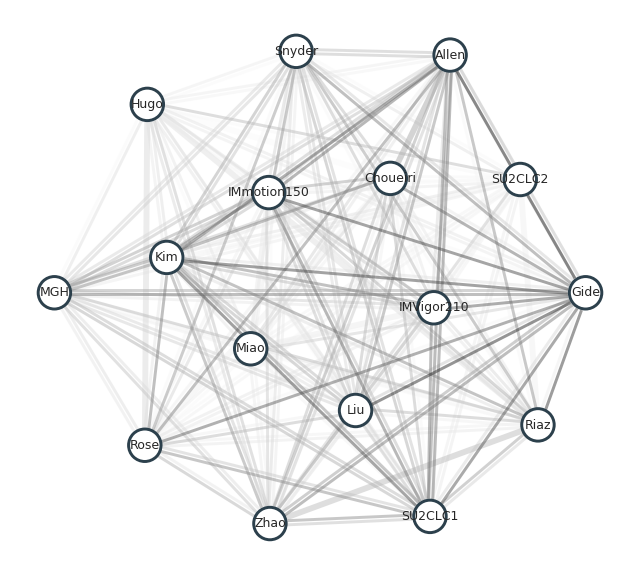

In [36]:
from netgraph import Graph, get_arced_edge_paths, get_radial_tree_layout, get_geometric_layout # pip install netgraph
import networkx as nx
import matplotlib.pyplot as plt

G = nx.MultiDiGraph()
for index, row in data.iterrows():
    if  row['positive_transfer']:
        G.add_edge(row['train_cohort'], row['test_cohort'], mode = row['mode'], weight = row['ACC'])

plt.figure(figsize=(8, 8))
layout = nx.layout.spring_layout(G)
Graph(G, acyclic = 'radial', node_labels =True, node_label_fontdict = {'fontsize':9}) #, node_layout=layout
#nx.draw_networkx_labels(G, font_size=12) 

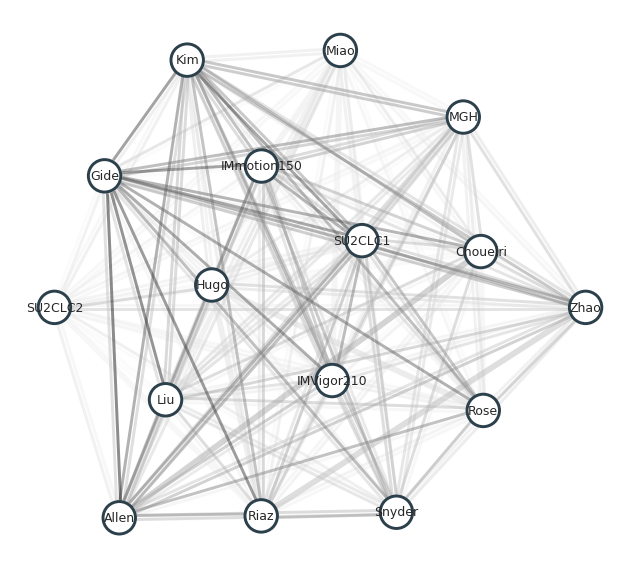

In [37]:
from netgraph import Graph, get_arced_edge_paths, get_radial_tree_layout, get_geometric_layout # pip install netgraph
import networkx as nx
import matplotlib.pyplot as plt

G = nx.MultiDiGraph()
for index, row in data.iterrows():
    if  row['positive_transfer']:
        G.add_edge(row['train_cohort'], row['test_cohort'], mode = row['mode'], weight = row['ACC'])

plt.figure(figsize=(8, 8))
layout = nx.layout.spring_layout(G)
Graph(G, acyclic = 'radial', node_labels =True, node_label_fontdict = {'fontsize':9}) #, node_layout=layout
#nx.draw_networkx_labels(G, font_size=12) 

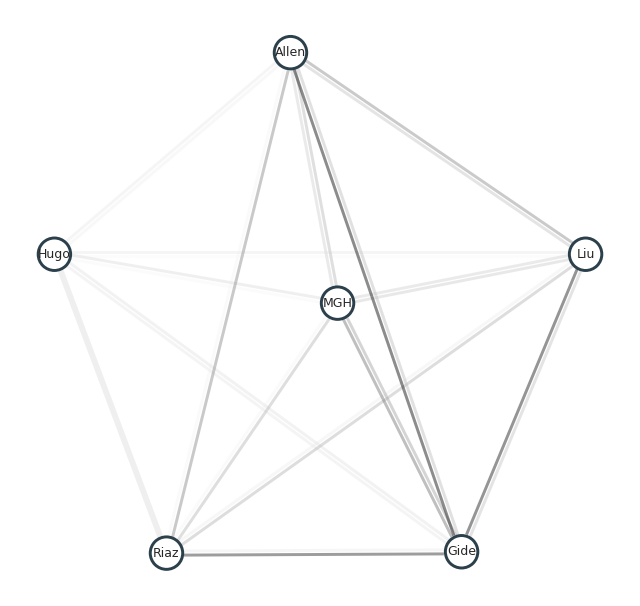

In [38]:
from netgraph import Graph, get_arced_edge_paths, get_radial_tree_layout, get_geometric_layout # pip install netgraph
import networkx as nx
import matplotlib.pyplot as plt

G = nx.MultiDiGraph()
for index, row in mdata.iterrows():
    if  row['positive_transfer']:
        G.add_edge(row['train_cohort'], row['test_cohort'], mode = row['mode'], weight = row['ACC'])

plt.figure(figsize=(8, 8))
layout = nx.layout.spring_layout(G)
Graph(G, acyclic = 'radial', node_labels =True, node_label_fontdict = {'fontsize':9}) #, node_layout=layout
#nx.draw_networkx_labels(G, font_size=12) 

In [39]:
# pt1 = data[data.positive_transfer].test_cohort.value_counts().to_frame('postive_transfer_as_a_test_cohort')
# pt2 = data[data.negative_transfer].test_cohort.value_counts().to_frame('negative_transfer_as_a_test_cohort')
# ptp = pt1.join(pt2)